# Assessing Working Memory Capacity of ChatGPT

In [1]:
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import math
from tabulate import tabulate
from scipy.stats import norm, ttest_ind, f_oneway, t, shapiro, levene, mannwhitneyu, wilcoxon, kruskal
import itertools
from matplotlib.ticker import MaxNLocator
import google.generativeai as genai
# openai.api_key = ''
from dotenv import load_dotenv
load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env'))

# openai.api_key = os.getenv('OPENAI_API_KEY')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)

c:\Users\User\anaconda3\envs\ftec5660\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\AppData\Local\Temp\ipykernel_33748\478497963.py:14: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [2]:

def generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences):
    sequences = []
    for _ in range(num_sequences):
        seq, conditions = [], []
        match_positions = random.sample(range(n, seq_length), matches)
        match_positions.sort()

        for i in range(seq_length):
            if i in match_positions:
                seq.append(seq[i - n])
                conditions.append('m')
            else:
                random_letter = random.choice(alphabet)
                while i > n and seq[i - n] == random_letter:
                    random_letter = random.choice(alphabet)
                seq.append(random_letter)
                conditions.append('-')
        
        sequences.append((''.join(seq), ''.join(conditions)))

    return sequences

def save_sequences_to_files(folder, sequences):
    os.makedirs(folder, exist_ok=True)

    for i, (seq, conditions) in enumerate(sequences):
        with open(os.path.join(folder, f"{i}.txt"), "w") as file:
            file.write(f"{seq}\n{conditions}\n")

alphabet = 'bcdfghjklnpqrstvwxyz'
seq_length = 24
matches = 8
num_sequences = 50

for n in [1, 2, 3]:
    sequences = generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences)
    folder = os.path.join("letters", f"{n}back")
    save_sequences_to_files(folder, sequences)

In [3]:
n_list = [1, 2, 3]
blocks = 50

In [4]:

# read N-back task (N=1,2,3) sequences and conditions from txt files, in which the first line is the sequence and the second line is the condition
# and create a list of trials
# each trial is a dictionary with the following keys:
# - 'stimulus': the stimulus letter
# - 'target': the desired response letter
# - 'response': the received response letter
# - 'correct': whether the response was correct
# - 'rt': the response time

all_trials = {}
for n in n_list:
    for b in range(blocks):
        path = os.path.join(os.getcwd(), 'letters','{}back'.format(n), '{}.txt'.format(b))
        with open(path, 'r') as f:
            seq = f.readline().strip()
            cond = f.readline().strip()

        # create a list of trials
        trials = []
        for i in range(len(seq)):
            trial = {}
            trial['stimulus'] = seq[i]
            trial['target'] = cond[i]
            trial['response'] = ''
            trial['correct'] = ''
            trial['rt'] = ''
            trials.append(trial)

        all_trials['{}back_{}'.format(n, b)] = trials


In [5]:
# Cell: 1-back task

for b in range(blocks):
    model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=genai.GenerationConfig(temperature=1),
    )
    chat = model.start_chat(history=[])

    # External memory buffer stores PREVIOUS letters only (oldest -> newest).
    memory_buffer = []

    n = 1
    for i in range(len(all_trials['1back_{}'.format(b)])):
        input_letter = all_trials['1back_{}'.format(b)][i]['stimulus']
        print(f'block {b}, trial {i}: {input_letter} (target: {all_trials["1back_{}".format(b)][i]["target"]})')

        # Determine target letter from exactly n steps ago USING ONLY the buffer (do not include current letter yet).
        target_letter = memory_buffer[0] if len(memory_buffer) == n else None
        memory_buffer_str = " ".join(memory_buffer) if memory_buffer else "(empty)"
        target_letter_str = target_letter if target_letter is not None else "None"

        prompt = f"""You are doing a {n}-back match task using ONLY an external memory buffer.

Rules:
- Output exactly one character: m or -
- If the target letter is None (not enough history), output -
- Do not use any internal memory, do not guess, do not explain.

[External Memory Buffer]
Previous letters (oldest -> newest): {memory_buffer_str}
Target letter from exactly {n} step(s) ago: {target_letter_str}
Current letter: {input_letter}
"""

        start_time = time.time()
        response = chat.send_message(prompt)
        response_time = time.time() - start_time

        all_trials['1back_{}'.format(b)][i]['rt'] = response_time
        print(f"Response time: {response_time:.2f} seconds")

        chat_response = response.text.strip()
        print(f'Gemini: {chat_response}')

        if chat_response == 'm':
            all_trials['1back_{}'.format(b)][i]['response'] = 'm'
            all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == 'm'
        elif chat_response == '-':
            all_trials['1back_{}'.format(b)][i]['response'] = '-'
            all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == '-'
        else:
            print('Rule violation! Extracting the first character of the response.')
            chat_response_0 = chat_response.strip()[0] if chat_response.strip() else ''
            if chat_response_0 == 'm':
                all_trials['1back_{}'.format(b)][i]['response'] = 'm'
                all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == 'm'
            elif chat_response_0 == '-':
                all_trials['1back_{}'.format(b)][i]['response'] = '-'
                all_trials['1back_{}'.format(b)][i]['correct'] = all_trials['1back_{}'.format(b)][i]['target'] == '-'
            else:
                raise ValueError('Invalid response. Please respond with "m" or "-".')

        # Update memory buffer AFTER the response (so it contains previous letters for the next trial).
        memory_buffer.append(input_letter)
        if len(memory_buffer) > n:
            memory_buffer = memory_buffer[-n:]

        print('correct' if all_trials['1back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')

    time.sleep(5)

block 0, trial 0: v (target: -)
Response time: 1.91 seconds
Gemini: -
correct
------------------------------------
block 0, trial 1: n (target: -)
Response time: 0.93 seconds
Gemini: -
correct
------------------------------------
block 0, trial 2: n (target: m)
Response time: 1.00 seconds
Gemini: m
correct
------------------------------------
block 0, trial 3: n (target: m)
Response time: 1.15 seconds
Gemini: m
correct
------------------------------------
block 0, trial 4: t (target: -)
Response time: 0.74 seconds
Gemini: -
correct
------------------------------------
block 0, trial 5: g (target: -)
Response time: 0.76 seconds
Gemini: -
correct
------------------------------------
block 0, trial 6: g (target: m)
Response time: 0.92 seconds
Gemini: m
correct
------------------------------------
block 0, trial 7: y (target: -)
Response time: 0.62 seconds
Gemini: -
correct
------------------------------------
block 0, trial 8: p (target: -)
Response time: 0.92 seconds
Gemini: -
correct
--

In [6]:
# Now for the 2-back task
for b in range(blocks):
    model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=genai.GenerationConfig(temperature=1),
    )
    chat = model.start_chat(history=[])

    # External memory buffer stores PREVIOUS letters only (oldest -> newest).
    memory_buffer = []
    n = 2

    for i in range(len(all_trials['2back_{}'.format(b)])):
        input_letter = all_trials['2back_{}'.format(b)][i]['stimulus']
        print(f'block {b}, trial {i}: {input_letter} (target: {all_trials["2back_{}".format(b)][i]["target"]})')

        target_letter = memory_buffer[0] if len(memory_buffer) == n else None
        memory_buffer_str = " ".join(memory_buffer) if memory_buffer else "(empty)"
        target_letter_str = target_letter if target_letter is not None else "None"

        prompt = f"""You are doing a {n}-back match task using ONLY an external memory buffer.

Rules:
- Output exactly one character: m or -
- If the target letter is None (not enough history), output -
- Do not use any internal memory, do not guess, do not explain.

[External Memory Buffer]
Previous letters (oldest -> newest): {memory_buffer_str}
Target letter from exactly {n} step(s) ago: {target_letter_str}
Current letter: {input_letter}
"""

        start_time = time.time()
        response = chat.send_message(prompt)
        response_time = time.time() - start_time

        all_trials['2back_{}'.format(b)][i]['rt'] = response_time
        print(f"Response time: {response_time:.2f} seconds")

        chat_response = response.text.strip()
        print(f'Gemini: {chat_response}')

        if chat_response == 'm':
            all_trials['2back_{}'.format(b)][i]['response'] = 'm'
            all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == 'm'
        elif chat_response == '-':
            all_trials['2back_{}'.format(b)][i]['response'] = '-'
            all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == '-'
        else:
            print('Rule violation! Extracting the first character of the response.')
            chat_response_0 = chat_response.strip()[0] if chat_response.strip() else ''

            if chat_response_0 != 'm' and chat_response_0 != '-':
                # Retry once
                retry_response = chat.send_message("Invalid. Output only one character: m or -.")
                chat_response = retry_response.text.strip()
                print(f'Gemini (retry): {chat_response}')
                chat_response_0 = chat_response.strip()[0] if chat_response.strip() else ''

            if chat_response_0 != 'm' and chat_response_0 != '-':
                print('Still invalid. Forcing wrong answer.')
                chat_response = '-' if all_trials['2back_{}'.format(b)][i]['target'] == 'm' else 'm'
            else:
                chat_response = chat_response_0

            all_trials['2back_{}'.format(b)][i]['response'] = chat_response
            all_trials['2back_{}'.format(b)][i]['correct'] = all_trials['2back_{}'.format(b)][i]['target'] == chat_response

        # Update memory buffer AFTER the response (so it contains previous letters for the next trial).
        memory_buffer.append(input_letter)
        if len(memory_buffer) > n:
            memory_buffer = memory_buffer[-n:]

        print('correct' if all_trials['2back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')

    time.sleep(5)

block 0, trial 0: w (target: -)
Response time: 1.25 seconds
Gemini: -
correct
------------------------------------
block 0, trial 1: q (target: -)
Response time: 0.95 seconds
Gemini: -
correct
------------------------------------
block 0, trial 2: w (target: m)
Response time: 1.53 seconds
Gemini: m
correct
------------------------------------
block 0, trial 3: z (target: -)
Response time: 0.63 seconds
Gemini: -
correct
------------------------------------
block 0, trial 4: t (target: -)
Response time: 0.93 seconds
Gemini: -
correct
------------------------------------
block 0, trial 5: z (target: m)
Response time: 0.92 seconds
Gemini: m
correct
------------------------------------
block 0, trial 6: w (target: -)
Response time: 0.99 seconds
Gemini: -
correct
------------------------------------
block 0, trial 7: z (target: m)
Response time: 0.72 seconds
Gemini: m
correct
------------------------------------
block 0, trial 8: k (target: -)
Response time: 0.73 seconds
Gemini: -
correct
--

In [7]:
# Now for the 3-back task
for b in range(blocks):
    model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=genai.GenerationConfig(temperature=1),
    )
    chat = model.start_chat(history=[])

    # External memory buffer stores PREVIOUS letters only (oldest -> newest).
    memory_buffer = []
    n = 3

    for i in range(len(all_trials['3back_{}'.format(b)])):
        input_letter = all_trials['3back_{}'.format(b)][i]['stimulus']
        print(f'block {b}, trial {i}: {input_letter} (target: {all_trials["3back_{}".format(b)][i]["target"]})')

        target_letter = memory_buffer[0] if len(memory_buffer) == n else None
        memory_buffer_str = " ".join(memory_buffer) if memory_buffer else "(empty)"
        target_letter_str = target_letter if target_letter is not None else "None"

        prompt = f"""You are doing a {n}-back match task using ONLY an external memory buffer.

Rules:
- Output exactly one character: m or -
- If the target letter is None (not enough history), output -
- Do not use any internal memory, do not guess, do not explain.

[External Memory Buffer]
Previous letters (oldest -> newest): {memory_buffer_str}
Target letter from exactly {n} step(s) ago: {target_letter_str}
Current letter: {input_letter}
"""

        start_time = time.time()
        response = chat.send_message(prompt)
        response_time = time.time() - start_time

        all_trials['3back_{}'.format(b)][i]['rt'] = response_time
        print(f"Response time: {response_time:.2f} seconds")

        chat_response = response.text.strip()
        print(f'Gemini: {chat_response}')

        if chat_response == 'm':
            all_trials['3back_{}'.format(b)][i]['response'] = 'm'
            all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == 'm'
        elif chat_response == '-':
            all_trials['3back_{}'.format(b)][i]['response'] = '-'
            all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == '-'
        else:
            print('Rule violation! Extracting the first character of the response.')
            chat_response_0 = chat_response.strip()[0] if chat_response.strip() else ''

            if chat_response_0 != 'm' and chat_response_0 != '-':
                # Retry once
                retry_response = chat.send_message("Invalid. Output only one character: m or -.")
                chat_response = retry_response.text.strip()
                print(f'Gemini (retry): {chat_response}')
                chat_response_0 = chat_response.strip()[0] if chat_response.strip() else ''

            if chat_response_0 != 'm' and chat_response_0 != '-':
                print('Still invalid. Forcing wrong answer.')
                chat_response = '-' if all_trials['3back_{}'.format(b)][i]['target'] == 'm' else 'm'
            else:
                chat_response = chat_response_0

            all_trials['3back_{}'.format(b)][i]['response'] = chat_response
            all_trials['3back_{}'.format(b)][i]['correct'] = all_trials['3back_{}'.format(b)][i]['target'] == chat_response

        # Update memory buffer AFTER the response (so it contains previous letters for the next trial).
        memory_buffer.append(input_letter)
        if len(memory_buffer) > n:
            memory_buffer = memory_buffer[-n:]

        print('correct' if all_trials['3back_{}'.format(b)][i]['correct'] else 'incorrect')
        print('------------------------------------')

    time.sleep(5)

block 0, trial 0: b (target: -)
Response time: 1.68 seconds
Gemini: -
correct
------------------------------------
block 0, trial 1: g (target: -)
Response time: 0.89 seconds
Gemini: -
correct
------------------------------------
block 0, trial 2: h (target: -)
Response time: 0.80 seconds
Gemini: -
correct
------------------------------------
block 0, trial 3: b (target: m)
Response time: 1.29 seconds
Gemini: m
correct
------------------------------------
block 0, trial 4: g (target: m)
Response time: 0.84 seconds
Gemini: m
correct
------------------------------------
block 0, trial 5: g (target: -)
Response time: 0.95 seconds
Gemini: -
correct
------------------------------------
block 0, trial 6: x (target: -)
Response time: 1.17 seconds
Gemini: -
correct
------------------------------------
block 0, trial 7: l (target: -)
Response time: 0.88 seconds
Gemini: -
correct
------------------------------------
block 0, trial 8: r (target: -)
Response time: 1.00 seconds
Gemini: -
correct
--

In [8]:
# save all_trials to a json file
with open('1155250674_all_trials_letters_gemini-2.5-flash-full_external.json', 'w') as f:
    json.dump(all_trials, f)


In [9]:
# load all_trials from a json file
with open('1155250674_all_trials_letters_gemini-2.5-flash-full_external.json', 'r') as f:
    all_trials = json.load(f)

In [10]:
def compute_summary_stats(all_trials, n_list, blocks):
    summary_stats = {}
    raw_data = {}
    for n in n_list:
        hit_rate, false_alarm_rate, accuracy, response_time, d_prime = [], [], [], [], []
        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            # Compute the hit rate, false alarm rate, and response time
            hits, false_alarms, total_targets, total_lures, total_rt = 0, 0, 0, 0, 0
            for trial in trials:
                if trial['target'] == 'm':
                    total_targets += 1
                    if trial['correct']:
                        hits += 1
                        total_rt += trial['rt']
                else:
                    total_lures += 1
                    if not trial['correct']:
                        false_alarms += 1

            hit_rate.append((hits / total_targets) * 100)
            false_alarm_rate.append((false_alarms / total_lures) * 100)
            accuracy.append(((hits + (total_lures - false_alarms)) / (total_targets + total_lures)) * 100)
            response_time.append(total_rt / hits if hits > 0 else np.nan)

            # Compute d prime
            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99)
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99)
            d_prime.append(np.abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted)))

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "d_prime": d_prime
        }
            
        summary_stats[n] = {
            "hit_rate": {"mean": np.mean(hit_rate),  "stderr": np.std(hit_rate) / math.sqrt(blocks)},
            "false_alarm_rate": {"mean": np.mean(false_alarm_rate), "stderr": np.std(false_alarm_rate) / math.sqrt(blocks)},
            "accuracy": {"mean": np.mean(accuracy), "stderr": np.std(accuracy) / math.sqrt(blocks)},
            "d_prime": {"mean": np.mean(d_prime), "stderr": np.std(d_prime) / math.sqrt(blocks)}
        }
    return summary_stats, raw_data

def create_table(summary_stats, n_list):
    headers = ["N-back", "Hit Rate (%)", "False Alarm Rate (%)",
               "Accuracy (%)", "D Prime"]

    table_data = []
    for n in n_list:
        row = [f"{n}-back",
               f"{summary_stats[n]['hit_rate']['mean']:.2f} ± {summary_stats[n]['hit_rate']['stderr']:.2f}",
               f"{summary_stats[n]['false_alarm_rate']['mean']:.2f} ± {summary_stats[n]['false_alarm_rate']['stderr']:.2f}",
               f"{summary_stats[n]['accuracy']['mean']:.2f} ± {summary_stats[n]['accuracy']['stderr']:.2f}",
               f"{summary_stats[n]['d_prime']['mean']:.2f} ± {summary_stats[n]['d_prime']['stderr']:.2f}"]
        table_data.append(row)

    table_str = tabulate(table_data, headers=headers, tablefmt="latex_booktabs")
    return table_str

# Compute summary statistics
summary_stats, raw_data = compute_summary_stats(all_trials, n_list, blocks)

# Create and print the table in LaTeX format
latex_table = create_table(summary_stats, n_list)
print(latex_table)


\begin{tabular}{lllll}
\toprule
 N-back   & Hit Rate (\%)   & False Alarm Rate (\%)   & Accuracy (\%)   & D Prime     \\
\midrule
 1-back   & 100.00 ± 0.00  & 0.00 ± 0.00            & 100.00 ± 0.00  & 4.65 ± 0.00 \\
 2-back   & 100.00 ± 0.00  & 1.50 ± 0.49            & 99.00 ± 0.32   & 4.49 ± 0.05 \\
 3-back   & 100.00 ± 0.00  & 0.12 ± 0.12            & 99.92 ± 0.08   & 4.64 ± 0.02 \\
\bottomrule
\end{tabular}


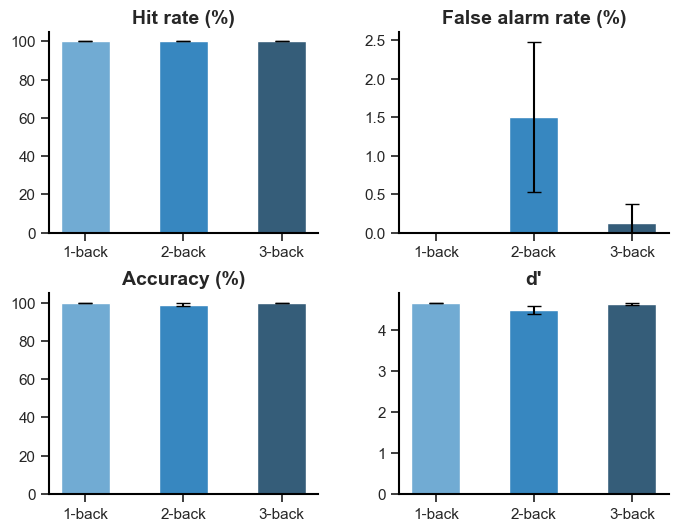

In [11]:
# def plot_metrics(summary_stats, n_list, ci_level=0.95):
#     # Set seaborn style and font size
#     sns.set(style="whitegrid")
#     plt.rcParams.update({'font.size': 12})

#     # Bar plot for accuracy, hit rate, false alarm rate, and d prime
#     fig, axes = plt.subplots(2, 2, figsize=(8, 6))
#     metrics = ["hit_rate", "false_alarm_rate","accuracy", "d_prime"]
#     titles = ["Hit rate (%)", "False alarm rate (%)", "Accuracy (%)", "d'"]

#     for i, ax in enumerate(axes.flat):
#         metric = metrics[i]
#         means = [summary_stats[n][metric]["mean"] for n in n_list]
#         stderrs = [summary_stats[n][metric]["stderr"] for n in n_list]
#         # Compute 95% confidence intervals
#         critical_value = t.ppf((1 + ci_level) / 2, blocks - 1)
#         cis = [critical_value * stderr for stderr in stderrs]
#         # Choose either standard errors or confidence intervals for error bars
#         error_bars = cis # Change this to 'stderrs' for standard errors
#         bar_plot = sns.barplot(x=n_list, y=means, yerr=error_bars, ax=ax, palette="Blues_d")
#         ax.set_title(titles[i], fontsize=14, fontweight='bold')
#         ax.set_xticklabels([f"{n}-back" for n in n_list])
#         ax.set_ylim(bottom=0)
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         # remove the grid lines
#         ax.grid(False)
#         # set the weight  and color of axes lines
#         ax.spines['bottom'].set_linewidth(1.5)
#         ax.spines['left'].set_linewidth(1.5)
#         ax.spines['bottom'].set_color('black')
#         ax.spines['left'].set_color('black')
#         # show tick lines on the left and bottom axes
#         ax.tick_params(axis='both', which='both', bottom=True, left=True)


#     # layout setting: adjust the space between subplots
#     plt.subplots_adjust(wspace=0.3, hspace=0.3)
#     plt.show()
    
#     # save the figure to a svg file in the figures folder
#     fig.savefig(os.path.join("figures", "letter_nback_metrics.svg"), format="svg")

# plot_metrics(summary_stats, n_list)

def plot_metrics(summary_stats, n_list, ci_level=0.95):
    # Set seaborn style and font size
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Bar plot for accuracy, hit rate, false alarm rate, and d prime
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    metrics = ["hit_rate", "false_alarm_rate","accuracy", "d_prime"]
    titles = ["Hit rate (%)", "False alarm rate (%)", "Accuracy (%)", "d'"]

    for i, ax in enumerate(axes.flat):
        metric = metrics[i]
        means = [summary_stats[n][metric]["mean"] for n in n_list]
        stderrs = [summary_stats[n][metric]["stderr"] for n in n_list]
        # Compute 95% confidence intervals
        critical_value = t.ppf((1 + ci_level) / 2, blocks - 1)
        cis = [critical_value * stderr for stderr in stderrs]
        error_bars = cis

        # Use matplotlib bar + errorbar instead of sns.barplot with yerr
        x_pos = np.arange(len(n_list))
        colors = sns.color_palette("Blues_d", len(n_list))
        bars = ax.bar(x_pos, means, color=colors, width=0.5)
        ax.errorbar(x_pos, means, yerr=error_bars, fmt='none', color='black', capsize=5, linewidth=1.5)

        ax.set_title(titles[i], fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f"{n}-back" for n in n_list])
        ax.set_ylim(bottom=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.tick_params(axis='both', which='both', bottom=True, left=True)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

    # save the figure to a svg file in the figures folder
    os.makedirs("figures", exist_ok=True)
    fig.savefig(os.path.join("figures", "letter_nback_metrics.svg"), format="svg")

plot_metrics(summary_stats, n_list)

In [12]:
def statistical_test(summary_stats, raw_data, n_list, blocks, alpha=0.05):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"ANOVA for {metric}:")

        # Prepare the data for ANOVA
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform ANOVA
        F, p = f_oneway(*data)

        # Calculate degrees of freedom
        df_between = len(n_list) - 1
        df_within = blocks * len(n_list) - len(n_list)

        # Calculate partial eta squared
        ss_total = np.sum([(d - np.mean(data))**2 for d in itertools.chain.from_iterable(data)])
        ss_effect = sum(blocks * (np.mean(data[i]) - np.mean(np.concatenate(data)))**2 for i in range(len(n_list)))
        partial_eta_squared = ss_effect / (ss_effect + ss_total)

        print(f"  F({df_between}, {df_within}) = {F:.4f}, p = {p:.4f}, partial eta squared = {partial_eta_squared:.4f}")

        # Perform post-hoc t-tests
        print("  Post-hoc t-tests:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # t-test
            t_stat, p_value = ttest_ind(data1, data2)

            # Calculate degrees of freedom for t-test
            df_t = 2 * blocks - 2

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate Cohen's d
            pooled_std = np.sqrt((np.std(data1)**2 + np.std(data2)**2) / 2)
            cohen_d = (np.mean(data1) - np.mean(data2)) / pooled_std

            print(f"    {n1}-back vs {n2}-back: t({df_t}) = {t_stat:.4f}, p = {corrected_p:.4f}, Cohen's d = {cohen_d:.4f}")

        print()

statistical_test(summary_stats, raw_data, n_list, blocks)

ANOVA for hit_rate:
  F(2, 147) = nan, p = nan, partial eta squared = nan
  Post-hoc t-tests:
    1-back vs 2-back: t(98) = nan, p = nan, Cohen's d = nan
    1-back vs 3-back: t(98) = nan, p = nan, Cohen's d = nan
    2-back vs 3-back: t(98) = nan, p = nan, Cohen's d = nan

ANOVA for false_alarm_rate:
  F(2, 147) = 8.0957, p = 0.0005, partial eta squared = 0.0903
  Post-hoc t-tests:
    1-back vs 2-back: t(98) = -3.0551, p = 0.0087, Cohen's d = -0.6172
    1-back vs 3-back: t(98) = -1.0000, p = 0.9593, Cohen's d = -0.2020
    2-back vs 3-back: t(98) = 2.7139, p = 0.0236, Cohen's d = 0.5483

ANOVA for accuracy:
  F(2, 147) = 8.0957, p = 0.0005, partial eta squared = 0.0903
  Post-hoc t-tests:
    1-back vs 2-back: t(98) = 3.0551, p = 0.0087, Cohen's d = 0.6172
    1-back vs 3-back: t(98) = 1.0000, p = 0.9593, Cohen's d = 0.2020
    2-back vs 3-back: t(98) = -2.7139, p = 0.0236, Cohen's d = -0.5483

ANOVA for d_prime:
  F(2, 147) = 8.5770, p = 0.0003, partial eta squared = 0.0946
  Post-

C:\Users\User\AppData\Local\Temp\ipykernel_33748\706336838.py:20: RuntimeWarning: invalid value encountered in scalar divide
  partial_eta_squared = ss_effect / (ss_effect + ss_total)
c:\Users\User\anaconda3\envs\ftec5660\Lib\site-packages\scipy\stats\_axis_nan_policy.py:592: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\User\AppData\Local\Temp\ipykernel_33748\706336838.py:42: RuntimeWarning: invalid value encountered in scalar divide
  cohen_d = (np.mean(data1) - np.mean(data2)) / pooled_std


In [13]:
# check the normality of the data
def check_normality(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Normality test for {metric}:")

        # Prepare the data for normality test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform normality test
        W, p = shapiro(np.concatenate(data))

        print(f"  W = {W:.4f}, p = {p:.4f}")

        print()

check_normality(raw_data, n_list, blocks)


Normality test for hit_rate:
  W = 1.0000, p = 1.0000

Normality test for false_alarm_rate:
  W = 0.2662, p = 0.0000

Normality test for accuracy:
  W = 0.2662, p = 0.0000

Normality test for d_prime:
  W = 0.2756, p = 0.0000



c:\Users\User\anaconda3\envs\ftec5660\Lib\site-packages\scipy\stats\_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [14]:
# check the homogeneity of the variance
def check_homogeneity(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Levene's test for {metric}:")

        # Prepare the data for homogeneity test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform homogeneity test
        W, p = levene(*data)

        print(f"  W = {W:.4f}, p = {p:.4f}")

        print()

check_homogeneity(raw_data, n_list, blocks)


Levene's test for hit_rate:
  W = nan, p = nan

Levene's test for false_alarm_rate:
  W = 8.0957, p = 0.0005

Levene's test for accuracy:
  W = 8.0957, p = 0.0005

Levene's test for d_prime:
  W = 8.5770, p = 0.0003



c:\Users\User\anaconda3\envs\ftec5660\Lib\site-packages\scipy\stats\_morestats.py:3326: RuntimeWarning: invalid value encountered in divide
  W = numer / denom


Distribution plot for hit_rate:


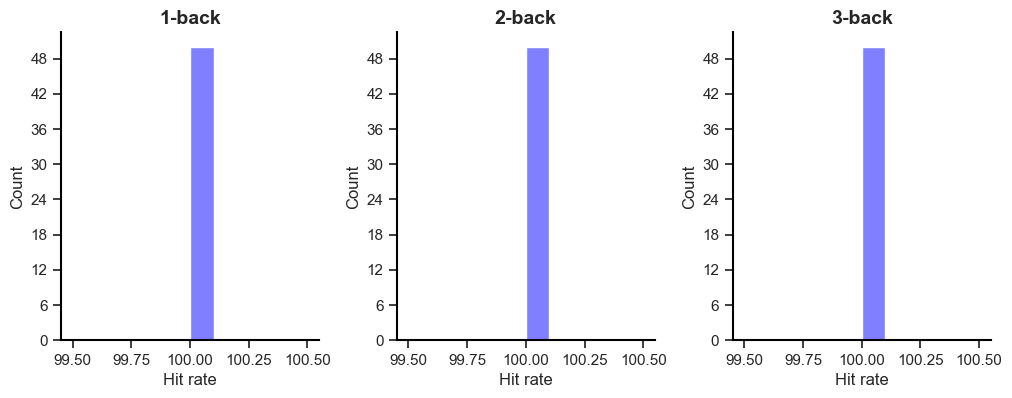

Distribution plot for false_alarm_rate:


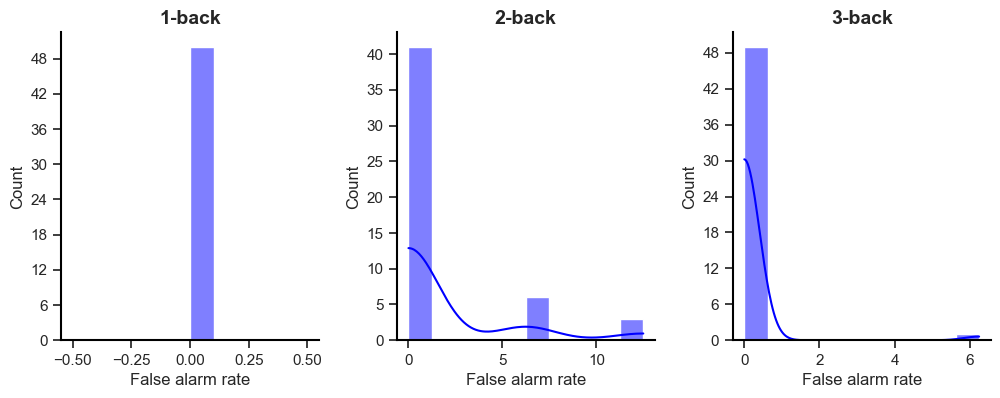

Distribution plot for accuracy:


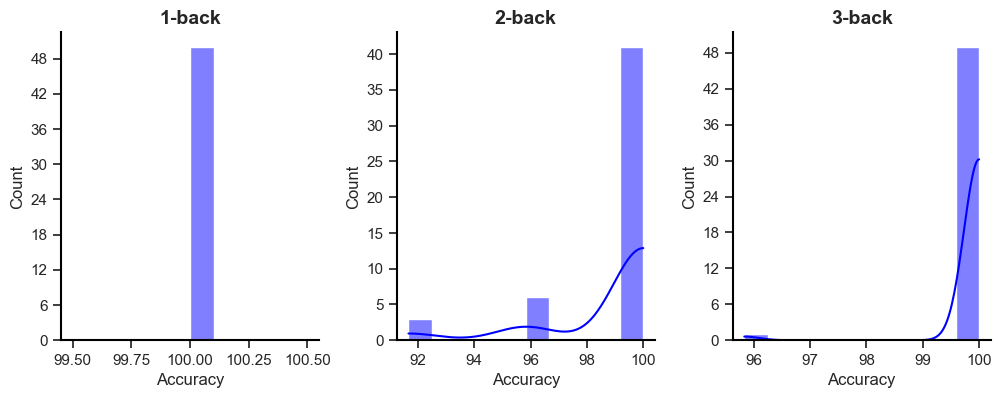

Distribution plot for d_prime:


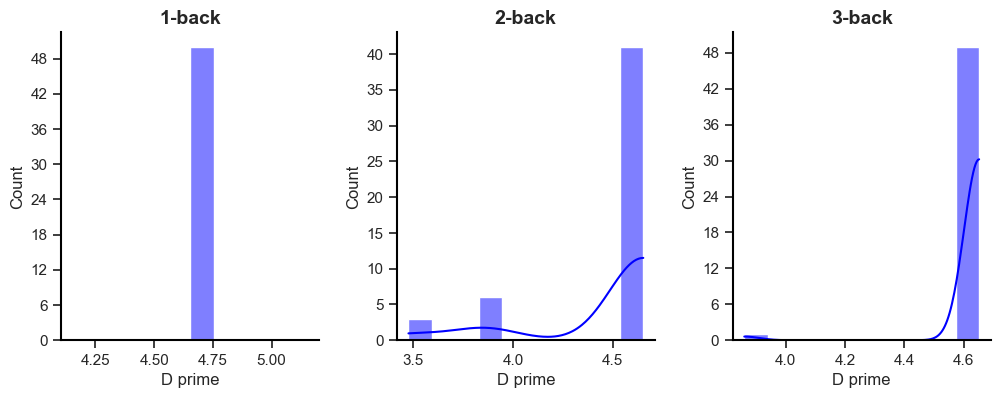

In [15]:
# plot the distribution of the data
def plot_distribution(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Distribution plot for {metric}:")

        # Prepare the data for distribution plot
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform distribution plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for i, ax in enumerate(axes.flat):
            sns.histplot(data[i], ax=ax, color="blue", bins=10, kde=True, stat='count')
            # sns.displot(data[i], ax=ax, kde=True, color="black")
            # sns.distplot(data[i], ax=ax, color="blue")
            ax.set_title(f"{n_list[i]}-back", fontsize=14, fontweight='bold')
            ax.set_xlabel(metric.replace("_", " ").capitalize())
            ax.set_ylabel("Count")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # remove the grid lines
            ax.grid(False)
            # set the weight  and color of axes lines
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            # show tick lines on the left and bottom axes
            ax.tick_params(axis='both', which='both', bottom=True, left=True)
            # set y ticks to be integers
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        # layout setting: adjust the space between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.show()

plot_distribution(raw_data, n_list, blocks)

In [19]:
# As normality test and homogeneity test show that the data is not normal and the variance is not homogeneous, we use the non-parametric test
def nonparametric_test(summary_stats, raw_data, n_list, blocks, alpha=0.05):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Kruskal-Wallis test for {metric}:")

        # Prepare the data for Kruskal-Wallis test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform Kruskal-Wallis test
        H, p = kruskal(*data)

        # Calculate degrees of freedom
        df = len(n_list) - 1

        # Calculate the total number of observations
        N = len(raw_data[n_list[0]][metric]) * len(n_list)
        
        # Calculate epsilon squared (ε²):ε² = (H - k + 1) / (N - k), where H is the Kruskal-Wallis H statistic, k is the number of groups (in your case, len(n_list)), N is the total number of observations across all groups
        epsilon_squared = (H - len(n_list) + 1) / (N - len(n_list))

        print(f"  H({df}) = {H:.4f}, p = {p:.4f}, epsilon squared = {epsilon_squared:.4f}")

        # Perform post-hoc Mann-Whitney U test
        print("  Post-hoc Mann-Whitney U test:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # Mann-Whitney U test
            U, p_value = mannwhitneyu(data1, data2)

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate the effect size using the rank-biserial correlation (r): r = 1 – (2U)/ (n1 * n2)
            r = 1 - (2 * U) / (len(data1) * len(data2))

            print(f"    {n1}-back vs {n2}-back: U = {U:.4f}, p = {corrected_p:.4f}, rank-biserial correlation(r) = {r:.4f}")

        print()

nonparametric_test(summary_stats, raw_data, n_list, blocks)

Kruskal-Wallis test for hit_rate:
  H(2) = nan, p = nan, epsilon squared = nan
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 1250.0000, p = 1.0000, rank-biserial correlation(r) = 0.0000
    1-back vs 3-back: U = 1250.0000, p = 1.0000, rank-biserial correlation(r) = 0.0000
    2-back vs 3-back: U = 1250.0000, p = 1.0000, rank-biserial correlation(r) = 0.0000

Kruskal-Wallis test for false_alarm_rate:
  H(2) = 15.6254, p = 0.0004, epsilon squared = 0.0927
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 1025.0000, p = 0.0054, rank-biserial correlation(r) = 0.1800
    1-back vs 3-back: U = 1225.0000, p = 0.9813, rank-biserial correlation(r) = 0.0200
    2-back vs 3-back: U = 1451.5000, p = 0.0232, rank-biserial correlation(r) = -0.1612

Kruskal-Wallis test for accuracy:
  H(2) = 15.6254, p = 0.0004, epsilon squared = 0.0927
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 1475.0000, p = 0.0054, rank-biserial correlation(r) = -0.1800
    1-back vs 3-back: U = 